✅ Combined dataset shape: (43020, 687)
✅ Columns: ['hour_ts', 'start_station_name', 'start_station_id', 'ride_count', 'hour', 'hour_sin', 'hour_cos', 'day_of_week', 'is_holiday_or_weekend', 'month', 'is_peak_hour', 'day_of_year', 'time_of_day', 'ride_count_roll3', 'target_ride_count', 'ride_count_lag_1', 'ride_count_lag_2', 'ride_count_lag_3', 'ride_count_lag_4', 'ride_count_lag_5', 'ride_count_lag_6', 'ride_count_lag_7', 'ride_count_lag_8', 'ride_count_lag_9', 'ride_count_lag_10', 'ride_count_lag_11', 'ride_count_lag_12', 'ride_count_lag_13', 'ride_count_lag_14', 'ride_count_lag_15', 'ride_count_lag_16', 'ride_count_lag_17', 'ride_count_lag_18', 'ride_count_lag_19', 'ride_count_lag_20', 'ride_count_lag_21', 'ride_count_lag_22', 'ride_count_lag_23', 'ride_count_lag_24', 'ride_count_lag_25', 'ride_count_lag_26', 'ride_count_lag_27', 'ride_count_lag_28', 'ride_count_lag_29', 'ride_count_lag_30', 'ride_count_lag_31', 'ride_count_lag_32', 'ride_count_lag_33', 'ride_count_lag_34', 'ride_cou

C:\Users\MD\AppData\Local\Temp\ipykernel_15888\1806179572.py:91: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MD\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


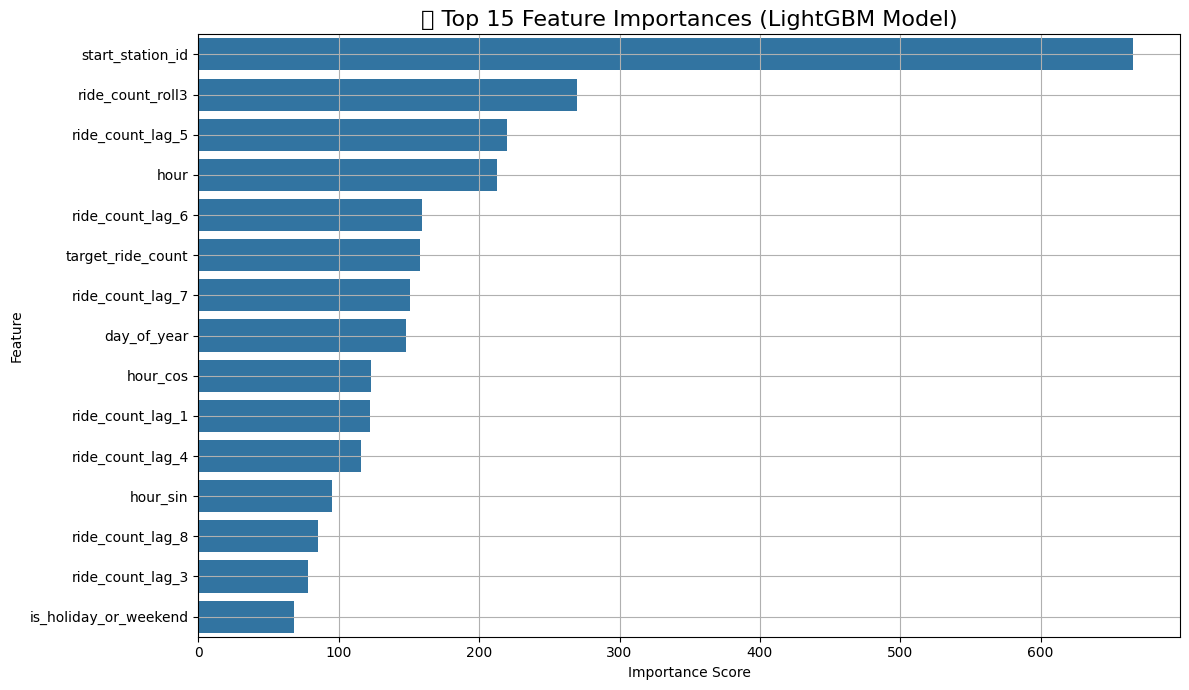

In [2]:
# 📦 IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pathlib import Path
from datetime import datetime
from pytz import timezone

# 🛠 Correct Python path if needed
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# 📚 Import utility function
from src.utils import split_time_series_data

# 🎯 Load Feature+Target Data
df_2024 = pd.read_parquet(r"C:\Users\MD\Desktop\citi\data\processed\final_features\rides_citibike_final_2024_with_lags.parquet")

# ✅ Combine
df = pd.concat([df_2024]).reset_index(drop=True)
print(f"✅ Combined dataset shape: {df.shape}")
print(f"✅ Columns: {df.columns.tolist()}")

# ✅ Correct the cutoff date (timezone-aware)
eastern = timezone("America/New_York")
cutoff_date = eastern.localize(datetime(2025, 1, 1, 0, 0, 0))

# ✅ Split
X_train, y_train, X_test, y_test = split_time_series_data(
    df,
    cutoff_date=cutoff_date,
    target_column="ride_count"
)

# ✅ Drop text columns that LightGBM can't handle
X_train = X_train.drop(columns=["start_station_name", "time_of_day", "hour_ts"], errors="ignore")
X_test = X_test.drop(columns=["start_station_name", "time_of_day", "hour_ts"], errors="ignore")

print(f"✅ Final X_train shape: {X_train.shape}")
print(f"✅ Final X_test shape: {X_test.shape}")

# ==========================
# 📈 Train LightGBM Model
# ==========================
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define the model
lgbm_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

print("🚀 Training LightGBM model...")
lgbm_model.fit(X_train, y_train)

# 🔮 Predict
y_pred_lgbm = lgbm_model.predict(X_test)

# 📊 Metrics
mae = mean_absolute_error(y_test, y_pred_lgbm)
mse = mean_squared_error(y_test, y_pred_lgbm)
rmse = np.sqrt(mse)

print(f"✅ LightGBM MAE: {mae:.2f}")
print(f"✅ LightGBM RMSE: {rmse:.2f}")

# ==========================
# 📈 Feature Importance
# ==========================

# Feature Importance plot
feature_importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": lgbm_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(15))  # Top 15 features
plt.title("🚀 Top 15 Feature Importances (LightGBM Model)", fontsize=16)
plt.xlabel("Importance Score")
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
import mlflow
import dagshub
from dotenv import load_dotenv

# 🛠 Load environment variables
load_dotenv()

# 🛠 Initialize DagsHub MLflow connection (ONLY ONCE per session)
dagshub.init(repo_owner="duddukuntamaneesh", repo_name="citi", mlflow=True)

# 🧠 Start MLflow run to log LightGBM metrics
with mlflow.start_run(run_name="LightGBM_Model"):
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("RMSE", rmse)
    print("✅ LightGBM MAE, MSE, RMSE logged to DagsHub successfully!")


Accessing as duddukuntamaneesh

Initialized MLflow to track repo "duddukuntamaneesh/citi"

Repository duddukuntamaneesh/citi initialized!

✅ LightGBM MAE, MSE, RMSE logged to DagsHub successfully!
🏃 View run LightGBM_Model at: https://dagshub.com/duddukuntamaneesh/citi.mlflow/#/experiments/0/runs/fd91139a59c9442996dc26df4b424bd9
🧪 View experiment at: https://dagshub.com/duddukuntamaneesh/citi.mlflow/#/experiments/0
